In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import time
from PIL import Image
from torchvision.models import resnet50
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets

In [ ]:
! unzip 'archive.zip'

In [2]:
train_transform = transforms.Compose([transforms.Resize(255),transforms.RandomResizedCrop(224),
                                transforms.CenterCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ColorJitter(),
                                transforms.ToTensor()])
test_transform = transforms.Compose([
                                transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

In [7]:
train_data = datasets.ImageFolder("data/train/", transform=train_transform)
test_data = datasets.ImageFolder("data/test/", transform=test_transform)

In [8]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=16,shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16)

In [14]:
print(trainloader.dataset.classes)

['hot_dog', 'not_hot_dog']


In [18]:
for images, classes in trainloader:
  logps=model.forward(inputs)
  break
logps

tensor([[0.5236],
        [0.7109]], device='cuda:0', grad_fn=<AddmmBackward0>)

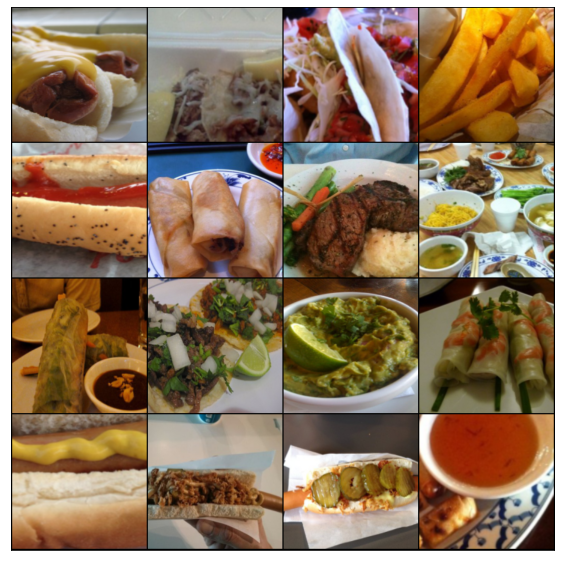

In [10]:
from torchvision.utils import make_grid
for images, labels in trainloader:
  
    
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = resnet50(pretrained=True)
device="cpu"

In [ ]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 1),
                                 nn.Sigmoid())

criterion = nn.BCELoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

In [ ]:
epochs = 2
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        print(logps)
        loss = criterion(logps, torch.reshape(labels, (-1,1)).to(torch.float))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, torch.reshape(labels, (-1,1)).to(torch.float))
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = (top_class == labels.view(*top_class.shape))
                    accuracy +=torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'better_model.pth')